In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [22]:
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from joblib import delayed, Parallel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib_pretty_tex as pgf

In [23]:
import utils

In [24]:
sns.set_style('whitegrid')

In [3]:
job_ids = {
    '0': 'Original_DB',
    '1': 'tip_x=0um_y=-250um',
    '2': 'tip_x=0um_y=-250um_sigma=0.5',
    '3': 'tip_x=0um_y=+100um_sigma=0.5',
    '4': 'tip_x=0um_y=-100um',
    '5': 'tip_x=0um_y=+1000um',
    '6': 'tip_x=0um_y=-1000um_sigma=0.5',
    '7': 'tip_x=0um_y=-100um_sigma=0.5',
    '9': 'tip_x=0um_y=+1000um_sigma=0.5',
    '10': 'tip_x=0um_y=-500um',
    '11': 'Nominal',
    '12': 'tip_x=0um_y=-1000um',
    '13': 'tip_x=0um_y=+100um',
    '14': 'tip_x=0um_y=+500um_sigma=0.5',
    '15': 'tip_x=0um_y=+500um',
    '17': 'tip_x=0um_y=+250um_sigma=0.5',
    '18': 'tip_x=0um_y=-500um_sigma=0.5',
    '19': 'tip_x=0um_y=+250um',
    '20': 'tip_x=0um_y=+1000um_sigma=0.5_alternate',
    '21': 'tip_x=0um_y=-1000um_sigma=0.5_alternate',
    '22': 'tip_x=0um_y=-1000um_alternate',
    '23': 'tip_x=0um_y=+1000um_alternate',
}

In [4]:
from glob import glob
import re
from collections import namedtuple
fn_pattern = 'output/ganga/(\d+)/(\d+)/output/PrCheckerInfo\.txt'
ScenarioInfo = namedtuple('ScenarioInfo', [
    'velo_ghost_rate',
    'velo_eff', 'velo_clone', 'long_eff', 'long_clone',
    'best_ghost_rate',
    'best_eff', 'best_clone',
])

In [5]:
def format_label(s):
    if s == 'Original_DB' or s == 'Nominal':
        return 'Nominal'
    elif s.startswith('tip_x=0um_y='):
        if s.endswith('_alternate'):
            s = s[:-len('_alternate')]
            alternate = ' alt'
        else:
            alternate = ''
        s = s[len('tip_x=0um_y='):]
        s = s.split('_sigma=')
        
        if len(s) == 2:
            mu, sigma = s
            sigma = ' $\\sigma$ = \\SI{{{}}}{{\\micro\\meter}}'.format(sigma)
        else:
            mu, = s
            sigma = ''
        return '$\\mu$ = \\SI{{{}}}{{\\micro\\meter}}{}{}'.format(mu[:-2], sigma, alternate)
    else:
        raise ValueError(s)

```bash
for f in */*/output/Script1_Ganga_GaudiExec.log; do
awk '/PrChecker.Velo       INFO \*\*/ {print; for(i=1; i<=196; i++) {getline; print}}' $f > ${f:h}/PrCheckerInfo.txt
done
```

In [6]:
info = {}
for fn in glob('output/ganga/*/1/output/PrCheckerInfo.txt'):
    j_id, sj_id = re.match(fn_pattern, fn).groups()
    with open(fn) as f:
        lines = [list(filter(None, l.strip().split(' '))) for l in f.readlines()]
    velo_summary = lines[0]
    velo_summary_total = int(velo_summary[4])
    velo_summary_ghosts = int(velo_summary[7])
    velo_summary_ghost_average = velo_summary[14]
    velo_velo = lines[1]
    velo_velo_reco = int(velo_velo[4])
    velo_velo_total = int(velo_velo[6])
    velo_velo_clones = int(velo_velo[10])
    velo_long = lines[2]
    velo_long_reco = int(velo_velo[4])
    velo_long_total = int(velo_velo[6])
    velo_long_clones = int(velo_velo[10])
    velo_longhighpt = lines[3]
    velo_longhighpt_reco = int(velo_velo[4])
    velo_longhighpt_total = int(velo_velo[6])
    velo_longhighpt_clones = int(velo_velo[10])
    best_summary = lines[68]
    best_summary_total = int(best_summary[4])
    best_summary_ghosts = int(best_summary[7])
    best_summary_ghost_average = best_summary[13]
    best_long = lines[69]
    best_long_reco = int(best_long[4])
    best_long_total = int(best_long[6])
    best_long_clones = int(best_long[10])
    info[job_ids[j_id]] = ScenarioInfo(
        velo_ghost_rate='{:.1%} ({}%)'.format(velo_summary_ghosts/velo_summary_total, velo_summary_ghost_average),
        velo_eff='{:.1%}'.format(velo_velo_reco/velo_velo_total),
        velo_clone='{:.1%}'.format(velo_velo_clones/(velo_velo_total+velo_velo_clones)),
        long_eff='{:.1%}'.format(velo_long_reco/velo_long_total),
        long_clone='{:.1%}'.format(velo_long_clones/(velo_long_total+velo_long_clones)),
        best_ghost_rate='{:.1%} ({}%)'.format(best_summary_ghosts/best_summary_total, best_summary_ghost_average),
        best_eff='{:.1%}'.format(best_long_reco/best_long_total),
        best_clone='{:.1%}'.format(best_long_clones/(best_long_total+best_long_clones))
    )
    print(job_ids[j_id])
    print('\n'.join([' '.join(x) for x in lines[0:5]]))
    print()
    print('\n'.join([' '.join(x) for x in lines[68:73]]))
    print()
    print()
    # print(
    #     job_ids[j_id].rjust(30),
    #     'Efficiency = {:.1%}'.format(velo_velo_reco/velo_velo_total),
    #     'Clone rate = {:.1%}'.format(velo_velo_clones/(velo_velo_total+velo_velo_clones)),
    #     'Ghost rate (average) = {:.1%} ({}%)'.format(velo_summary_ghosts/velo_summary_total, velo_summary_ghost_average),
    #     sep='\t'
    # )
    # print(best_summary)

Original_DB
PrChecker.Velo INFO **** Velo 244121 tracks including 5892 ghosts [ 2.4 %], Event average 1.9 % ****
PrChecker.Velo INFO velo : 121749 from 123419 [ 98.6 %] 4650 clones [ 3.7 %], purity: 99.78 %, hitEff: 93.78 %
PrChecker.Velo INFO long : 73870 from 74224 [ 99.5 %] 1651 clones [ 2.2 %], purity: 99.82 %, hitEff: 96.36 %
PrChecker.Velo INFO long>5GeV : 47512 from 47680 [ 99.6 %] 888 clones [ 1.8 %], purity: 99.84 %, hitEff: 96.97 %
PrChecker.Velo INFO long_strange : 3642 from 3699 [ 98.5 %] 60 clones [ 1.6 %], purity: 99.19 %, hitEff: 96.95 %

PrChecker.Best INFO **** Best 287778 tracks including 35279 ghosts [12.3 %], Event average 10.4 % ****
PrChecker.Best INFO long : 73335 from 74224 [ 98.8 %] 4059 clones [ 5.2 %], purity: 99.10 %, hitEff: 90.19 %
PrChecker.Best INFO long>5GeV : 47238 from 47680 [ 99.1 %] 2225 clones [ 4.5 %], purity: 99.16 %, hitEff: 92.38 %
PrChecker.Best INFO long_strange : 3624 from 3699 [ 98.0 %] 220 clones [ 5.7 %], purity: 98.62 %, hitEff: 87.86 %


In [7]:
if 'Original_DB' in info:
    del info['Original_DB']

In [11]:
import tabulate
def key(x):
    if x[0] in ('Original_DB', 'Nominal'):
        return 0
    elif 'alternate' in x[0]:
        return int(x[0][12:12+x[0][12:].index('um')])+10000
    else:
        return int(x[0][12:12+x[0][12:].index('um')])

raw_table = [[k, *v] for k, v in sorted(info.items(), key=key)]
table = tabulate.tabulate(
    raw_table,
    headers=['Scenario', 'Ghost rate (average)', 'Velo efficiency', 'Velo clones', 'Long efficiency',
             'Long clones', 'Best ghost rate (average)', 'Best efficiency', 'Best clones'],
    tablefmt='latex_booktabs'
)
for k in info:
    table = table.replace(k.replace('_', '\\_'), format_label(k))
print(table)

\begin{tabular}{lllllllll}
\toprule
 Scenario                                & Ghost rate (average)   & Velo efficiency   & Velo clones   & Long efficiency   & Long clones   & Best ghost rate (average)   & Best efficiency   & Best clones   \\
\midrule
 $\mu$ = \SI{-1000}{\micro\meter}                     & 2.4\% (1.9\%)            & 98.6\%             & 3.7\%          & 98.6\%             & 3.7\%          & 12.3\% (10.4\%)               & 98.8\%             & 5.3\%          \\
 $\mu$ = \SI{-1000}{\micro\meter}\_sigma=0.5           & 5.6\% (4.4\%)            & 97.2\%             & 6.9\%          & 97.2\%             & 6.9\%          & 13.7\% (11.6\%)               & 98.7\%             & 7.9\%          \\
 $\mu$ = \SI{-500}{\micro\meter}                      & 2.4\% (1.9\%)            & 98.6\%             & 3.7\%          & 98.6\%             & 3.7\%          & 12.3\% (10.4\%)               & 98.8\%             & 5.2\%          \\
 $\mu$ = \SI{-500}{\micro\meter}\_sigma=0.5            & 

In [36]:
raw_table

[['tip_x=0um_y=-1000um',
  '2.4% (1.9%)',
  '98.6%',
  '3.7%',
  '98.6%',
  '3.7%',
  '12.3% (10.4%)',
  '98.8%',
  '5.3%'],
 ['tip_x=0um_y=-1000um_sigma=0.5',
  '5.6% (4.4%)',
  '97.2%',
  '6.9%',
  '97.2%',
  '6.9%',
  '13.7% (11.6%)',
  '98.7%',
  '7.9%'],
 ['tip_x=0um_y=-500um',
  '2.4% (1.9%)',
  '98.6%',
  '3.7%',
  '98.6%',
  '3.7%',
  '12.3% (10.4%)',
  '98.8%',
  '5.2%'],
 ['tip_x=0um_y=-500um_sigma=0.5',
  '4.0% (3.2%)',
  '97.7%',
  '5.1%',
  '97.7%',
  '5.1%',
  '12.8% (10.9%)',
  '98.8%',
  '6.2%'],
 ['tip_x=0um_y=-250um_sigma=0.5',
  '2.6% (2.0%)',
  '98.5%',
  '4.1%',
  '98.5%',
  '4.1%',
  '12.3% (10.4%)',
  '98.8%',
  '5.4%'],
 ['tip_x=0um_y=-250um',
  '2.4% (1.9%)',
  '98.6%',
  '3.6%',
  '98.6%',
  '3.6%',
  '12.3% (10.4%)',
  '98.8%',
  '5.2%'],
 ['tip_x=0um_y=-100um_sigma=0.5',
  '2.5% (1.9%)',
  '98.6%',
  '3.7%',
  '98.6%',
  '3.7%',
  '12.3% (10.4%)',
  '98.8%',
  '5.2%'],
 ['tip_x=0um_y=-100um',
  '2.4% (1.9%)',
  '98.6%',
  '3.6%',
  '98.6%',
  '3.6%',
  '12.3

In [54]:
import re
from collections import defaultdict
rate = defaultdict(dict)
for scenario, velo_ghost, velo_eff, velo_clone, long_eff, long_clone, best_ghost, best_eff, best_clone in raw_table:
    match = re.search('([+-])(\\d+)um(_sigma=0.5)?$', scenario)
    if 'Nominal' == scenario:
        nominal = float(velo_ghost[-5:-2])
    if not match:
        continue
    assert 'alt' not in scenario
    sign, magnitiude, sigma = match.groups()
    rate[(sign, sigma)][int(magnitiude)] = velo_ghost
    print(sign, magnitiude, sigma, scenario)

- 1000 None tip_x=0um_y=-1000um
- 1000 _sigma=0.5 tip_x=0um_y=-1000um_sigma=0.5
- 500 None tip_x=0um_y=-500um
- 500 _sigma=0.5 tip_x=0um_y=-500um_sigma=0.5
- 250 _sigma=0.5 tip_x=0um_y=-250um_sigma=0.5
- 250 None tip_x=0um_y=-250um
- 100 _sigma=0.5 tip_x=0um_y=-100um_sigma=0.5
- 100 None tip_x=0um_y=-100um
+ 100 _sigma=0.5 tip_x=0um_y=+100um_sigma=0.5
+ 100 None tip_x=0um_y=+100um
+ 250 None tip_x=0um_y=+250um
+ 250 _sigma=0.5 tip_x=0um_y=+250um_sigma=0.5
+ 500 _sigma=0.5 tip_x=0um_y=+500um_sigma=0.5
+ 500 None tip_x=0um_y=+500um
+ 1000 None tip_x=0um_y=+1000um
+ 1000 _sigma=0.5 tip_x=0um_y=+1000um_sigma=0.5


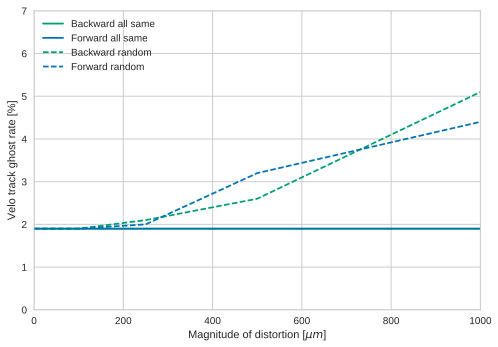

In [61]:
for sign, sigma in [('+', None), ('-', None), ('+', '_sigma=0.5'), ('-', '_sigma=0.5')]:
    xs = [100, 250, 500, 1000]
    ys = [float(rate[(sign, sigma)][x][-5:-2]) for x in xs]
    plt.plot(
        [0]+xs, [nominal]+ys,
        ls='--' if sigma else '-',
        c=sns.color_palette('colorblind', 2)[sign == '+'],
        label=f'{["Forward", "Backward"][sign == "+"]} {["all same", "random"][bool(sigma)]}'
    )
plt.xlim(0, 1000)
plt.ylim(0, 7)
plt.xlabel('Magnitude of distortion [$\mu m$]')
plt.ylabel('Velo track ghost rate [%]')
plt.legend(loc='upper left')
pgf.savefig('Velo_track_ghost.pgf.png')

In [48]:
best_clone_rate

defaultdict(dict,
            {('-', None): {100: '5.2%',
              250: '5.2%',
              500: '5.2%',
              1000: '5.3%'},
             ('-', '_sigma=0.5'): {100: '5.2%',
              250: '5.4%',
              500: '6.2%',
              1000: '7.9%'},
             ('+', '_sigma=0.5'): {100: '5.2%',
              250: '5.4%',
              500: '5.7%',
              1000: '12.2%'},
             ('+', None): {100: '5.2%',
              250: '5.2%',
              500: '5.2%',
              1000: '5.2%'}})